In [34]:
import os

In [35]:
os.chdir("../")

In [36]:
%pwd

'/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep'

# Config.yaml

In [ ]:

# # Configuration for spaCy Named Entity Recognition (NER) model training
# spacy_ner:
#   # Root directory for training artifacts
#   root_dir: artifacts/model_training/spacy_ner

#   ner_job_description_extractor_dir: "/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep/artifacts/model_training/NERJobDescriptionExtractor/Model"

#   # Path to annotated data
#   json_annotated_path: artifacts/model_training/spacy_ner/project-4-at-2024-04-01-07-30-2333a63c.json  
 
#   # Output path for the converted spaCy data
#   output_path: artifacts/model_training/spacy_ner/output/converted_data.spacy  

#   # Path to unannotated training data
#   train_data_path: artifacts/data_transformation/train_data.csv  

#   # Path to unannotated test data
#   test_data_path: artifacts/data_transformation/test_data.csv  

#   # Path to unannotated validation data
#   val_data_path: artifacts/data_transformation/val_data.csv  

#   # Processed spaCy training data
#   spacy_train: artifacts/model_training/spacy_ner/output/train_data.spacy  

#   # Processed spaCy dev (validation) data
#   spacy_dev: artifacts/model_training/spacy_ner/output/dev_data.spacy  

#   # Original dataset path
#   original_dataset_path: artifacts/data_ingestion/gsearch_jobs.csv

#   train_data_extracted_entities: artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/train_data_extracted_entities.csv

#   merged_output_path: artifacts/data_transformation/merged_train_data.csv

#   # Pretrained model directory
#   pretrained_model_dir: artifacts/model_training/NERJobDescriptionExtractor/Model

#   # Custom model directory
#   custom_model_dir: artifacts/model_training/spacy_ner/trained_model  

#   training_metrics_path_custom: artifacts/model_training/spacy_ner/output/training_metrics_ner_custom.csv

#   training_metrics_path_finetuned: artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/training_metrics_finetuned.csv

#   # GPU allocator (use 'pytorch' for PyTorch)
#   gpu_allocator: pytorch  

#   # NLP pipeline components
#   components:  
#     - name: "ner"
#       factory: "ner"

#   # Training parameters
#   training:  
#     batch_size: 128
#     dropout: 0.5
#     optimizer:
#       learn_rate: 0.001
#     patience: 3
#     max_epochs: 20

# Entity Class

In [4]:
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Any

@dataclass
class SpacyNERConfig:
    """
    Represents the configuration for spaCy Named Entity Recognition (NER) model training.
    
    Attributes:
        root_dir (Path): Directory for storing training artifacts and results.
        ner_job_description_extractor_dir (Path): Directory containing the NER job description extractor model.
        json_annotated_path (Path): Path to the JSON file with annotations from Label Studio.
        output_path (Path): Destination path for the converted spaCy data format.
        train_data_path (Path): Path to the CSV file containing unannotated training data.
        test_data_path (Path): Path to the CSV file containing unannotated test data.
        val_data_path (Path): Path to the CSV file containing unannotated validation data.
        spacy_train (Path): Path for the processed spaCy training data.
        spacy_dev (Path): Path for the processed spaCy development (validation) data.
        original_dataset_path (Path): Path to the original dataset used for entity extraction.
        train_data_extracted_entities (Path): Path for the CSV file with entities extracted from the training data.
        merged_output_path (Path): Path for the merged dataset after combining original data with extracted entities.
        pretrained_model_dir (Path): Directory containing the pretrained model for fine-tuning.
        custom_model_dir (Path): Directory intended for storing the custom-trained model.
        gpu_allocator (str): The GPU allocator for training, e.g., 'pytorch'.
        components (List[Dict[str, Any]]): Configuration for the NER pipeline components.
        training (Dict[str, Any]): Dictionary containing the training parameters.
    """
    root_dir: Path
    ner_job_description_extractor_dir: Path
    json_annotated_path: Path
    output_path: Path
    train_data_path: Path
    test_data_path: Path
    val_data_path: Path
    spacy_train: Path
    spacy_dev: Path
    original_dataset_path: Path
    train_data_extracted_entities: Path
    merged_output_path: Path
    pretrained_model_dir: Path
    custom_model_dir: Path
    gpu_allocator: str
    components: List[Dict[str, Any]]
    training: Dict[str, Any]
    training_metrics_path_custom: Path
    training_metrics_path_finetuned: Path


# Configuration Manager

In [5]:
from src.career_chief.constants import *
from src.career_chief.utils.common import read_yaml, create_directories
from src.career_chief import logger
from src.career_chief.entity.config_entity import (DataIngestionConfig, DataValidationConfig, SpacyNERConfig)

class ConfigurationManager:
    """
    ConfigurationManager manages configurations needed for the data pipeline.

    The class reads configuration, parameter, and schema settings from specified files
    and provides a set of methods to access these settings. It also takes care of
    creating necessary directories defined in the configurations.

    Attributes:
    - config (dict): Configuration settings.
    - params (dict): Parameters for the pipeline.
    - schema (dict): Schema information.
    """
    
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH, 
                 params_filepath = PARAMS_FILE_PATH, 
                 schema_filepath = SCHEMA_FILE_PATH) -> None:
        """
        Initialize ConfigurationManager with configurations, parameters, and schema.

        Args:
        - config_filepath (Path): Path to the configuration file.
        - params_filepath (Path): Path to the parameters file.
        - schema_filepath (Path): Path to the schema file.

        Creates:
        - Directories specified in the configuration.
        """
        self.config = self._read_config_file(config_filepath, "config")
        self.params = self._read_config_file(params_filepath, "params")
        self.schema = self._read_config_file(schema_filepath, "schema")

        # Create the directory for storing artifacts if it doesn't exist
        create_directories([self.config.artifacts_root])

    def _read_config_file(self, filepath: str, config_name: str) -> dict:
        """
        Read a configuration file and return its content.

        Args:
        - filepath (str): Path to the configuration file.
        - config_name (str): Name of the configuration (for logging purposes).

        Returns:
        - dict: Configuration settings.

        Raises:
        - Exception: If there's an error reading the file.
        """
        try:
            return read_yaml(filepath)
        except Exception as e:
            logger.error(f"Error reading {config_name} file: {filepath}. Error: {e}")
            raise

    
    def get_spacy_ner_config(self) -> SpacyNERConfig:
        """
        Fetches and constructs the spaCy NER training configuration.

        Extracts settings related to spaCy NER model training from the loaded YAML
        configurations and returns them encapsulated in a SpacyNERConfig object.

        Returns:
        - SpacyNERConfig: Configuration object for spaCy NER model training.

        Raises:
        - KeyError: If any required configuration is missing.
        """
        try:
            ner_config = self.config['spacy_ner']
            
            return SpacyNERConfig(
                root_dir=Path(ner_config['root_dir']),
                ner_job_description_extractor_dir=Path(ner_config['ner_job_description_extractor_dir']),
                json_annotated_path=Path(ner_config['json_annotated_path']),
                output_path=Path(ner_config['output_path']),
                train_data_path=Path(ner_config['train_data_path']),
                test_data_path=Path(ner_config['test_data_path']),
                val_data_path=Path(ner_config['val_data_path']),
                spacy_train=Path(ner_config['spacy_train']),
                spacy_dev=Path(ner_config['spacy_dev']),
                original_dataset_path=Path(ner_config['original_dataset_path']),
                train_data_extracted_entities=Path(ner_config['train_data_extracted_entities']),
                merged_output_path=Path(ner_config['merged_output_path']),
                pretrained_model_dir=Path(ner_config['pretrained_model_dir']),
                custom_model_dir=Path(ner_config['custom_model_dir']),
                gpu_allocator=ner_config.get('gpu_allocator', False),
                components=ner_config.get('components', []),
                training=ner_config['training'],
                training_metrics_path_custom=ner_config['training_metrics_path_custom'],
                training_metrics_path_finetuned=ner_config['training_metrics_path_finetuned']
            )
        except KeyError as e:
            logger.error(f"A required configuration is missing in the 'spacy_ner' section: {e}")
            raise KeyError(f"Missing configuration in 'spacy_ner': {e}") from e

# Components


In [38]:
import spacy
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from src.career_chief import logger  # Importing the logger

class EntityExtractorFromJobDescriptions:
    """
    A class for extracting entities from job descriptions using a fine-tuned NER model.

    Attributes:
        model_path (str): Path to the fine-tuned NER model.
        data_path (str): Path to the input CSV file containing job descriptions.
        output_path (str): Path where the extracted entities CSV file will be saved.
    """
    
    def __init__(self, model_path, data_path, output_path):
        """
        Initializes the EntityExtractorFromJobDescriptions with specified model, data, and output paths.
        
        Parameters:
            model_path (str): Path to the fine-tuned NER model.
            data_path (str): Path to the input CSV file.
            output_path (str): Path for the output CSV file with extracted entities.
        """
        self.model_path = model_path
        self.data_path = data_path
        self.output_path = output_path

    def load_model(self):
        """Loads the fine-tuned NER model from the specified path."""
        logger.info("Loading the fine-tuned NER model.")
        return spacy.load(self.model_path)

    def load_data(self):
        """Loads the job descriptions dataset from a CSV file."""
        logger.info(f"Loading data from {self.data_path}.")
        return pd.read_csv(self.data_path)

    def extract_and_save_entities(self):
        """
        Extracts entities from the job descriptions using the NER model and saves the results to a CSV file.
        Progress is tracked and logged.
        """
        nlp = self.load_model()
        data = self.load_data()

        # Convert all entries in the 'cleaned_text' column to strings to prevent type-related errors.
        data['cleaned_text'] = data['cleaned_text'].astype(str)

        results = []

        logger.info("Starting entity extraction from job descriptions.")
        
        # Process each job description in the dataset.
        for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Extracting entities"):
            doc = nlp(row['cleaned_text'])
            entities = [(ent.text, ent.label_) for ent in doc.ents]
            job_id = row['job_id']
            for entity_text, entity_label in entities:
                results.append({
                    "job_id": job_id,
                    "entity_text": entity_text,
                    "entity_label": entity_label
                })

        results_df = pd.DataFrame(results)
        
        # Ensuring the directory for the output file exists.
        Path(self.output_path).parent.mkdir(parents=True, exist_ok=True)
        
        # Saving the extracted entities to a CSV file.
        results_df.to_csv(self.output_path, index=False)
        logger.info(f"Extracted entities saved successfully to {self.output_path}.")

In [30]:
import pandas as pd
from src.career_chief import logger
from tqdm.auto import tqdm

class DatasetMerger:
    """
    Merges original job descriptions with extracted entities from NER models, with progress tracking.
    
    Attributes:
        original_dataset_path (str): Path to the original dataset CSV file.
        extracted_entities_path (str): Path to the extracted entities CSV file.
        output_path (str): Path for the merged dataset CSV output.
    """
    
    def __init__(self, dataset_path, extracted_entities_path, output_path):
        """
        Initializes DatasetMerger with file paths for datasets and output.
        """
        self.dataset_path = dataset_path
        self.extracted_entities_path = extracted_entities_path
        self.output_path = output_path

    def load_datasets_with_progress(self):
        """
        Loads the original and extracted entities datasets with progress tracking.
        
        Returns:
            tuple: A tuple containing two pandas DataFrames (original_df, extracted_entities_df).
        """
        logger.info("Loading original dataset with progress tracking.")
        # Assuming the original dataset might also be large and benefit from chunk loading
        dataset_path = pd.read_csv(self.dataset_path, chunksize=5000)
        dataset_path_df = pd.concat(tqdm(dataset_path, desc="Original Dataset"))

        logger.info("Loading extracted entities dataset with progress tracking.")
        extracted_entities_iter = pd.read_csv(self.extracted_entities_path, chunksize=5000)
        extracted_entities_df = pd.concat(tqdm(extracted_entities_iter, desc="Extracted Entities Dataset"))

        return dataset_path_df, extracted_entities_df

    def merge_datasets_with_progress(self, dataset_path, extracted_entities_df):
        """
        Merges the original and extracted entities datasets based on 'job_id'.
        
        Parameters:
            original_df (pd.DataFrame): The original dataset DataFrame.
            extracted_entities_df (pd.DataFrame): The extracted entities DataFrame.
            
        Returns:
            pd.DataFrame: The merged DataFrame.
        """
        logger.info("Merging datasets on 'job_id'.")
        # Directly merging as there's no iterative process to track with tqdm
        merged_df = pd.merge(dataset_path, extracted_entities_df, on='job_id', how='left')
        logger.info("Datasets merged successfully.")
        
        return merged_df

    def save_merged_dataset(self, merged_df):
        """
        Saves the merged dataset to a CSV file, with path specified during class initialization.
        
        Parameters:
            merged_df (pd.DataFrame): The merged dataset DataFrame to be saved.
        """
        logger.info(f"Saving merged dataset to {self.output_path}.")
        # Saving isn't directly trackable with tqdm but logging indicates progress
        merged_df.to_csv(self.output_path, index=False)
        logger.info("Merged dataset saved successfully.")



In [41]:
import spacy
from spacy.util import minibatch, compounding, load_config
from spacy.training.loop import train
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import subprocess
import re
import random
import json
from sklearn.model_selection import train_test_split
from spacy.tokens import DocBin
from spacy.training import Example
from src.career_chief import logger

class SpacyCustomNERModel:
    """
    A component for managing the entire NER pipeline using spaCy, including data processing,
    training, fine-tuning, entity extraction, and data merging.

    The class is initialized with a SpacyNERConfig object containing necessary paths and settings.
    """

    def __init__(self, config):
        """
        Initializes the SpacyCustomNERModel with necessary configurations.

        Parameters:
        - config (SpacyNERConfig): A configuration object with paths and settings for NER processing.
        """
        self.config = config
        self.nlp = spacy.blank("en")  # Initialize a blank English model
        self.ner = self.nlp.add_pipe("ner", last=True)  # Add NER to the pipeline
        
        # Direct attribute access from SpacyNERConfig object
        self.model_path = self.config.ner_job_description_extractor_dir
        self.json_annotated_path = self.config.json_annotated_path
        self.output_path = self.config.output_path
        self.train_data_path = self.config.train_data_path
        self.test_data_path = self.config.test_data_path
        self.val_data_path = self.config.val_data_path
        self.spacy_train = self.config.spacy_train
        self.spacy_dev = self.config.spacy_dev
        self.original_dataset_path = self.config.original_dataset_path  # Adjust as needed
        self.train_data_extracted_entities = self.config.train_data_extracted_entities
        self.merged_output_path = self.config.merged_output_path
        self.pretrained_model_dir = self.config.pretrained_model_dir
        self.custom_model_dir = self.config.custom_model_dir
        self.training_metrics_path_custom = config.training_metrics_path_custom
        self.training_metrics_path_finetuned = config.training_metrics_path_finetuned


    def process_annotations(self, data, nlp, progress_bar=None):
        """
        Processes annotations from JSON format into spaCy's binary format for NER training.
        
        Parameters:
            data (list): A list of dictionaries, each containing 'data' and 'annotations' keys.
            nlp (Language): A spaCy Language object, typically a blank model.
            progress_bar (tqdm, optional): An instance of tqdm for progress tracking.
        
        Returns:
            DocBin: A spaCy DocBin object containing the processed documents.
        """
        doc_bin = DocBin()  # Initialize DocBin to store processed documents.

        # Iterate over each annotated item in the input data.
        for item in data:
            # Extract text for the current item.
            text = item["data"]["text"]
            # Tokenize the text using the provided spaCy Language object.
            doc = nlp.make_doc(text)

            # Prepare a list to store entity spans.
            ents = []
            # Set to track existing spans and avoid overlaps.
            existing_spans = set()

            # Iterate over each annotation in the current item.
            for annot in item["annotations"][0]["result"]:
                # Extract start and end indices, and the entity label.
                start = annot["value"]["start"]
                end = annot["value"]["end"]
                label = annot["value"]["labels"][0]

                # Ensure the new span does not overlap with existing ones.
                if not any((start <= s < end) or (start < e <= end) for s, e in existing_spans):
                    # Create a span from the annotation.
                    span = doc.char_span(start, end, label=label, alignment_mode="strict")
                    # If the span is valid (i.e., not None), add it to the list of entities.
                    if span is not None:
                        ents.append(span)
                        # Record the span boundaries to check for future overlaps.
                        existing_spans.add((start, end))

            # Update the document with identified entities.
            doc.ents = ents
            # Add the document to DocBin.
            doc_bin.add(doc)
            
            # Update the progress bar if provided
            if progress_bar is not None:
                progress_bar.update(1)
        
        # Log completion of annotation processing.
        logger.info("Annotations processed successfully.")
        return doc_bin
    
    def split_and_save_data(self, docs, test_size=0.2, progress_bar=None):
        """
        Splits the list of spaCy Doc objects into training and development sets,
        then saves them as .spacy files.

        Args:
            docs (list): The full list of spaCy Doc objects.
            test_size (float): The proportion of the dataset to include in the test split.
            progress_bar (tqdm.tqdm, optional): A tqdm progress bar instance to track the progress. Defaults to None.
        """
        # Split the docs into training and development sets
        train_docs, dev_docs = train_test_split(docs, test_size=test_size, random_state=42)
        logger.info(f"Split data into {len(train_docs)} training and {len(dev_docs)} development examples.")

        # Save the train and dev DocBins
        train_bin = DocBin(docs=train_docs, store_user_data=True)
        dev_bin = DocBin(docs=dev_docs, store_user_data=True)
        train_bin.to_disk(self.config.spacy_train)
        dev_bin.to_disk(self.config.spacy_dev)
        logger.info("Training and development data saved successfully.")

        # Update the progress bar if provided
        if progress_bar is not None:
            progress_bar.update(1)

    def read_spacy_annotations(self, file_path):
        """
        Reads and prints spaCy annotations from a .spacy file for verification.

        Args:
            file_path (str): Path to the .spacy file containing annotated data.
        """
        nlp = spacy.blank("en")  # Load the blank English model
        doc_bin = DocBin().from_disk(file_path)  # Load the DocBin file
        docs = list(doc_bin.get_docs(nlp.vocab))  # Create a list of Doc objects

        for doc in docs:
            print(f"Text: {doc.text[:50]}...")  # Print document text
            for ent in doc.ents:
                print(f" - Entity: {ent.text}, Label: {ent.label_}")  # Print each entity and its label
            print("\n---\n")

        logger.info(f"Annotations from {file_path} read and printed for verification.")
        return docs
    
    def get_labels(self, docs):
        """
        Extracts unique entity labels from the provided spaCy documents.

        Args:
            docs (list of spacy.Doc): List of spaCy Doc objects containing annotations.

        Returns:
            set: A set containing unique entity labels.
        """
        labels = set()
        for doc in docs:
            for ent in doc.ents:
                labels.add(ent.label_)
        return labels
    

    def train_ner_model(self):
        """
        Trains the NER model using spaCy, evaluates its performance on the development set
        at each epoch, and saves the trained model along with performance metrics.
        """
        if self.config.gpu_allocator:
            spacy.require_gpu()
        nlp = spacy.blank("en")

        if 'ner' not in nlp.pipe_names:
            nlp.add_pipe('ner')
        ner = nlp.get_pipe('ner')

        train_docs = list(DocBin().from_disk(self.config.spacy_train).get_docs(nlp.vocab))
        dev_docs = list(DocBin().from_disk(self.config.spacy_dev).get_docs(nlp.vocab))

        for label in self.get_labels(train_docs + dev_docs):
            ner.add_label(label)

        training_metrics = []
        logger.info("Starting NER model training...")

        with nlp.disable_pipes([pipe for pipe in nlp.pipe_names if pipe != 'ner']):
            optimizer = nlp.begin_training()

            for epoch in tqdm(range(self.config.training["max_epochs"]), desc="Training Epochs"):
                random.shuffle(train_docs)
                losses = {}

                batches = minibatch(train_docs, size=compounding(4., 32., 1.001))
                for batch in tqdm(batches, leave=False, desc=f"Epoch {epoch}"):
                    examples = [Example.from_dict(nlp.make_doc(doc.text), {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in batch]
                    nlp.update(examples, drop=0.3, sgd=optimizer, losses=losses)

                dev_examples = [Example.from_dict(nlp.make_doc(doc.text), {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in dev_docs]
                scores = nlp.evaluate(dev_examples)

                training_metrics.append({
                    'epoch': epoch,
                    'loss': losses['ner'],
                    'precision': scores['ents_p'],
                    'recall': scores['ents_r'],
                    'f1': scores['ents_f']
                })

                logger.info(f"Epoch {epoch} - Loss: {losses['ner']}, Precision: {scores['ents_p']}, Recall: {scores['ents_r']}, F1: {scores['ents_f']}")

        model_save_path = self.config.custom_model_dir
        nlp.to_disk(model_save_path)
        logger.info(f"Trained model saved to {model_save_path}")

        metrics_save_path = self.config.training_metrics_path_custom
        pd.DataFrame(training_metrics).to_csv(metrics_save_path, index=False)
        logger.info(f"Training metrics saved to {metrics_save_path}")

    def visualize_training_metrics_custom_model(self, metrics_csv_path):
        """
        Visualizes the training metrics for the custom NER model including loss,
        precision, recall, and F1 scores over epochs.

        Args:
            metrics_csv_path (str): Path to the CSV file containing the training metrics.
        """
        # Load the metrics from the CSV file
        metrics_df = pd.read_csv(metrics_csv_path)

        # Set the visualization style
        sns.set(style="whitegrid")

        # Creating subplots for each metric
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Training Metrics Over Epochs')

        # Plotting loss
        sns.lineplot(data=metrics_df, x='epoch', y='loss', ax=axs[0, 0], marker='o', color='blue')
        axs[0, 0].set_title('Loss Over Epochs')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].set_ylabel('Loss')

        # Plotting precision
        sns.lineplot(data=metrics_df, x='epoch', y='precision', ax=axs[0, 1], marker='o', color='orange')
        axs[0, 1].set_title('Precision Over Epochs')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].set_ylabel('Precision')

        # Plotting recall
        sns.lineplot(data=metrics_df, x='epoch', y='recall', ax=axs[1, 0], marker='o', color='green')
        axs[1, 0].set_title('Recall Over Epochs')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].set_ylabel('Recall')

        # Plotting F1 score
        sns.lineplot(data=metrics_df, x='epoch', y='f1', ax=axs[1, 1], marker='o', color='red')
        axs[1, 1].set_title('F1 Score Over Epochs')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].set_ylabel('F1 Score')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
                      
    
    def finetune_pretrained_ner_model(self):
        """
        Fine-tunes a pretrained NER model using spaCy's train command.
        """
        if self.config.gpu_allocator:
            spacy.require_gpu()

        # Directory paths
        model_dir = Path(self.config.pretrained_model_dir)
        output_dir = model_dir / "finetuned_model"
        config_path = model_dir / "config.cfg"
        
        # Ensure output directory exists
        output_dir.mkdir(parents=True, exist_ok=True)

        # Prepare the spacy train command
        train_command = [
            "spacy", "train",
            str(config_path),
            "--output", str(output_dir),
            "--paths.train", str(self.spacy_train),
            "--paths.dev", str(self.spacy_dev),
            "--gpu-id", "0" if self.config.gpu_allocator else "-1"
        ]
        
        # Execute the training command and capture the output
        result = subprocess.run(train_command, capture_output=True, text=True)

        # Check for errors in the training process
        if result.returncode != 0:
            logger.error("Training failed with the following error:")
            logger.error(result.stderr)  # No need to decode, as text=True makes it a string
            return

        logger.info("Training completed successfully.")
        logger.info(result.stdout)
        
        # Parse the stdout to extract the metrics
        metrics_pattern = re.compile(r"\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)")
        epochs, losses_tok2vec, losses_ner, ents_f, ents_p, ents_r, score = [], [], [], [], [], [], []
        
        for line in result.stdout.split("\n"):
            match = metrics_pattern.search(line)
            if match:
                epoch, batch, loss_tok2vec, loss_ner, f, p, r, s = match.groups()
                epochs.append(int(epoch))
                losses_tok2vec.append(float(loss_tok2vec))
                losses_ner.append(float(loss_ner))
                ents_f.append(float(f))
                ents_p.append(float(p))
                ents_r.append(float(r))
                score.append(float(s))
        
        # Save the metrics to a DataFrame for further analysis or visualization
        metrics_df = pd.DataFrame({
            "Epoch": epochs,
            "Loss Tok2Vec": losses_tok2vec,
            "Loss NER": losses_ner,
            "ENTS_F": ents_f,
            "ENTS_P": ents_p,
            "ENTS_R": ents_r,
            "Score": score
        })
        
        # Define the correct path for saving the training metrics
        metrics_csv_path = self.config.training_metrics_path_finetuned
        metrics_df.to_csv(metrics_csv_path, index=False)
        logger.info(f"Training metrics saved to: {metrics_csv_path}")


    def visualize_training_metrics_finetuned(self, metrics_csv_path):
        """
        Visualizes training metrics including loss, F1 score, precision, recall, and score from a CSV file.

        Parameters:
        - metrics_csv_path (str): Path to the CSV file containing the training metrics.
        """
        # Load the metrics from the CSV file
        metrics_df = pd.read_csv(metrics_csv_path)

        # Setting the style
        sns.set(style="whitegrid")

        # Creating subplots for each type of analysis
        fig, ax = plt.subplots(3, 1, figsize=(14, 18))

        # Plotting Loss Tok2Vec and Loss NER
        sns.lineplot(x='Epoch', y='Loss Tok2Vec', data=metrics_df, marker='o', label='Loss Tok2Vec', ax=ax[0])
        sns.lineplot(x='Epoch', y='Loss NER', data=metrics_df, marker='o', label='Loss NER', ax=ax[0])
        ax[0].set_title('Loss Tok2Vec and Loss NER Over Epochs')
        ax[0].set_ylabel('Loss')
        ax[0].legend()

        # Plotting ENTS_F, ENTS_P, and ENTS_R
        sns.lineplot(x='Epoch', y='ENTS_F', data=metrics_df, marker='o', label='F-score', ax=ax[1])
        sns.lineplot(x='Epoch', y='ENTS_P', data=metrics_df, marker='o', label='Precision', ax=ax[1])
        sns.lineplot(x='Epoch', y='ENTS_R', data=metrics_df, marker='o', label='Recall', ax=ax[1])
        ax[1].set_title('Performance Metrics Over Epochs')
        ax[1].set_ylabel('Score')
        ax[1].legend()

        # Plotting the Overall Score
        sns.lineplot(x='Epoch', y='Score', data=metrics_df, marker='o', color='green', ax=ax[2])
        ax[2].set_title('Overall Score Over Epochs')
        ax[2].set_ylabel('Score')

        plt.tight_layout()
        plt.show()
        
    # Methods from EntityExtractorFromJobDescriptions
    def load_model(self):
        logger.info("Loading the fine-tuned NER model.")
        return spacy.load(self.model_path)

    def load_data(self):
        """Loads the job descriptions dataset from a CSV file."""
        logger.info(f"Loading data from {self.train_data_path}.")
        pd.read_csv(self.train_data_path)
        return pd.read_csv(self.train_data_path)


    def run(self):
        """
        Executes the NER pipeline: processing annotations, training, fine-tuning,
        extracting entities, and merging datasets.
        """
        try:
            logger.info("Starting NER pipeline.")
            with tqdm(total=8, desc="NER Pipeline Progress") as pbar:
                # Load and process annotations from JSON
                with open(self.config.json_annotated_path, 'r', encoding='utf-8') as f:
                    annotated_data = json.load(f)
                doc_bin = self.process_annotations(annotated_data, self.nlp)
                pbar.update(1)

                # Split and save data
                docs = list(doc_bin.get_docs(self.nlp.vocab))
                self.split_and_save_data(docs)
                pbar.update(1)

                # # Optionally read back the saved annotations for verification
                self.read_spacy_annotations(self.config.spacy_dev)
                pbar.update(1)

                # Train the custom NER model
                self.train_ner_model()
                pbar.update(1)

                # Visualize training metrics for the custom NER model
                self.visualize_training_metrics_custom_model(self.config.training_metrics_path_custom)
                pbar.update(1)

                # Fine-tune the pretrained NER model
                self.finetune_pretrained_ner_model()
                pbar.update(1)

                # Visualize training metrics for the fine-tuned NER model
                self.visualize_training_metrics_finetuned(self.config.training_metrics_path_finetuned)
                pbar.update(1)

                # Extract and save entities using the fine-tuned model
                model_path = "artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/model-best"
                data_path = "artifacts/data_transformation/train_data.csv"
                output_path = "artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/train_data_extracted_entities.csv"
                extract_ner = EntityExtractorFromJobDescriptions(model_path, data_path, output_path)
                extract_ner.extract_and_save_entities()
                pbar.update(1)

                # Initialize and use DatasetMerger
                # merger = DatasetMerger(self.train_data_path, self.train_data_extracted_entities, self.output_path)
                # train_dataset_df, extracted_entities_df = merger.load_datasets_with_progress()
                # merged_df = merger.merge_datasets_with_progress(train_dataset_df, extracted_entities_df)
                # merger.save_merged_dataset(merged_df)

            logger.info("Dataset merging process completed successfully.")
            pbar.update(1)

            logger.info("NER pipeline completed successfully.")

        except Exception as e:
            logger.error(f"Error occurred during the NER pipeline: {e}")
            raise




# Pipeline

[2024-04-11 15:11:09,030: 41: career_chief_logger: INFO: common:  yaml file: config/config.yaml loaded successfully]
[2024-04-11 15:11:09,072: 41: career_chief_logger: INFO: common:  yaml file: params.yaml loaded successfully]
[2024-04-11 15:11:09,075: 41: career_chief_logger: INFO: common:  yaml file: schema.yaml loaded successfully]
[2024-04-11 15:11:09,082: 64: career_chief_logger: INFO: common:  Created directory at: artifacts]
[2024-04-11 15:11:09,082: 22: career_chief_logger: INFO: 3306622033:  Custom NER spaCy Model Training Pipeline initialized successfully.]
[2024-04-11 15:11:09,089: 33: career_chief_logger: INFO: 3306622033:  Custom NER spaCy Model Training Pipeline: Fetching model configuration.]
[2024-04-11 15:11:09,101: 36: career_chief_logger: INFO: 3306622033:  Custom NER spaCy Model Training Pipeline: Initializing the SpacyCustomNERModel component.]
[2024-04-11 15:11:09,927: 39: career_chief_logger: INFO: 3306622033:  Custom NER spaCy Model Training Pipeline: Executing 

NER Pipeline Progress:   0%|          | 0/8 [00:00<?, ?it/s]

[2024-04-11 15:11:10,554: 108: career_chief_logger: INFO: 2833377599:  Annotations processed successfully.]


NER Pipeline Progress:  12%|█▎        | 1/8 [00:00<00:04,  1.65it/s]

[2024-04-11 15:11:10,784: 123: career_chief_logger: INFO: 2833377599:  Split data into 32 training and 9 development examples.]
[2024-04-11 15:11:13,544: 130: career_chief_logger: INFO: 2833377599:  Training and development data saved successfully.]


NER Pipeline Progress:  25%|██▌       | 2/8 [00:03<00:12,  2.01s/it]

Text: About Us:

Staffigo is in the business of providin...
 - Entity: providing IT Consulting Services, Label: Duties and Responsibilities
 - Entity: Healthcare, Label: Industry
 - Entity: Finance, Label: Industry
 - Entity: Banking, Label: Industry
 - Entity: Retail, Label: Industry
 - Entity: e-commerce, Label: Industry
 - Entity: Create, validate and send daily, weekly, and monthly management reports, Label: Duties and Responsibilities
 - Entity: Assistance with requests for non-standard reports and analysis for clients, Label: Duties and Responsibilities
 - Entity: maintaining the hierarchy of information Research, Label: Duties and Responsibilities
 - Entity: troubleshooting analysis of complex management reports, Label: Duties and Responsibilities
 - Entity: project requirements definition, Label: Duties and Responsibilities
 - Entity: Transform client needs into functional requirements, Label: Duties and Responsibilities
 - Entity: With guidance, collect, analyze and document b

NER Pipeline Progress:  38%|███▊      | 3/8 [00:04<00:07,  1.52s/it]

[2024-04-11 15:11:18,452: 193: career_chief_logger: INFO: 2833377599:  Starting NER model training...]


[2024-04-11 15:11:19,166] [INFO] Created vocabulary


[2024-04-11 15:11:19,166: 140: spacy: INFO: initialize:  Created vocabulary]


[2024-04-11 15:11:19,240] [INFO] Finished initializing nlp object


[2024-04-11 15:11:19,240: 151: spacy: INFO: initialize:  Finished initializing nlp object]


[2024-04-11 15:11:34,722: 218: career_chief_logger: INFO: 2833377599:  Epoch 0 - Loss: 19493.127127170563, Precision: 0.0, Recall: 0.0, F1: 0.0]


[2024-04-11 15:11:39,214: 218: career_chief_logger: INFO: 2833377599:  Epoch 1 - Loss: 10673.303952217102, Precision: 0.0, Recall: 0.0, F1: 0.0]


[2024-04-11 15:11:43,352: 218: career_chief_logger: INFO: 2833377599:  Epoch 2 - Loss: 4722.845316290855, Precision: 0.0, Recall: 0.0, F1: 0.0]


[2024-04-11 15:11:52,394: 218: career_chief_logger: INFO: 2833377599:  Epoch 3 - Loss: 3344.588343029842, Precision: 0.0, Recall: 0.0, F1: 0.0]


[2024-04-11 15:11:57,762: 218: career_chief_logger: INFO: 2833377599:  Epoch 4 - Loss: 3807.2597616520943, Precision: 0.0, Recall: 0.0, F1: 0.0]


[2024-04-11 15:12:04,950: 218: career_chief_logger: INFO: 2833377599:  Epoch 5 - Loss: 3710.15024907887, Precision: 0.0, Recall: 0.0, F1: 0.0]


[2024-04-11 15:12:10,456: 218: career_chief_logger: INFO: 2833377599:  Epoch 6 - Loss: 3444.3629803456133, Precision: 0.0, Recall: 0.0, F1: 0.0]


[2024-04-11 15:12:14,632: 218: career_chief_logger: INFO: 2833377599:  Epoch 7 - Loss: 3148.586472144816, Precision: 0.0, Recall: 0.0, F1: 0.0]


[2024-04-11 15:12:19,446: 218: career_chief_logger: INFO: 2833377599:  Epoch 8 - Loss: 2650.5143001759425, Precision: 0.8888888888888888, Recall: 0.019184652278177457, F1: 0.03755868544600939]


[2024-04-11 15:12:23,551: 218: career_chief_logger: INFO: 2833377599:  Epoch 9 - Loss: 3329.4683618011186, Precision: 0.19889502762430938, Recall: 0.08633093525179857, F1: 0.12040133779264214]


[2024-04-11 15:12:27,635: 218: career_chief_logger: INFO: 2833377599:  Epoch 10 - Loss: 2618.5488876997224, Precision: 0.4411764705882353, Recall: 0.07194244604316546, F1: 0.12371134020618556]


[2024-04-11 15:12:31,544: 218: career_chief_logger: INFO: 2833377599:  Epoch 11 - Loss: 3115.580976518977, Precision: 0.291044776119403, Recall: 0.09352517985611511, F1: 0.14156079854809436]


[2024-04-11 15:12:36,337: 218: career_chief_logger: INFO: 2833377599:  Epoch 12 - Loss: 2154.1388076362, Precision: 0.2755905511811024, Recall: 0.08393285371702638, F1: 0.1286764705882353]


[2024-04-11 15:12:40,448: 218: career_chief_logger: INFO: 2833377599:  Epoch 13 - Loss: 5277.737228791171, Precision: 0.049107142857142856, Recall: 0.026378896882494004, F1: 0.0343213728549142]


[2024-04-11 15:12:44,445: 218: career_chief_logger: INFO: 2833377599:  Epoch 14 - Loss: 3126.375496828463, Precision: 0.25157232704402516, Recall: 0.09592326139088729, F1: 0.13888888888888887]


[2024-04-11 15:12:48,645: 218: career_chief_logger: INFO: 2833377599:  Epoch 15 - Loss: 1930.278101500342, Precision: 0.22674418604651161, Recall: 0.09352517985611511, F1: 0.13242784380305603]


[2024-04-11 15:12:53,036: 218: career_chief_logger: INFO: 2833377599:  Epoch 16 - Loss: 2601.7927364419593, Precision: 0.2261904761904762, Recall: 0.09112709832134293, F1: 0.1299145299145299]


[2024-04-11 15:12:57,338: 218: career_chief_logger: INFO: 2833377599:  Epoch 17 - Loss: 3038.6317598318983, Precision: 0.19327731092436976, Recall: 0.11031175059952038, F1: 0.14045801526717558]


[2024-04-11 15:13:01,449: 218: career_chief_logger: INFO: 2833377599:  Epoch 18 - Loss: 3035.945397544652, Precision: 0.24705882352941178, Recall: 0.10071942446043165, F1: 0.14310051107325383]


[2024-04-11 15:13:06,033: 218: career_chief_logger: INFO: 2833377599:  Epoch 19 - Loss: 2692.9292591280537, Precision: 0.0851063829787234, Recall: 0.009592326139088728, F1: 0.017241379310344827]


Training Epochs: 100%|██████████| 20/20 [01:45<00:00,  5.26s/it]

[2024-04-11 15:13:06,192: 222: career_chief_logger: INFO: 2833377599:  Trained model saved to artifacts/model_training/spacy_ner/trained_model]


[2024-04-11 15:13:06,253: 226: career_chief_logger: INFO: 2833377599:  Training metrics saved to artifacts/model_training/spacy_ner/output/training_metrics_ner_custom.csv]


NER Pipeline Progress:  50%|█████     | 4/8 [01:56<03:00, 45.05s/it]

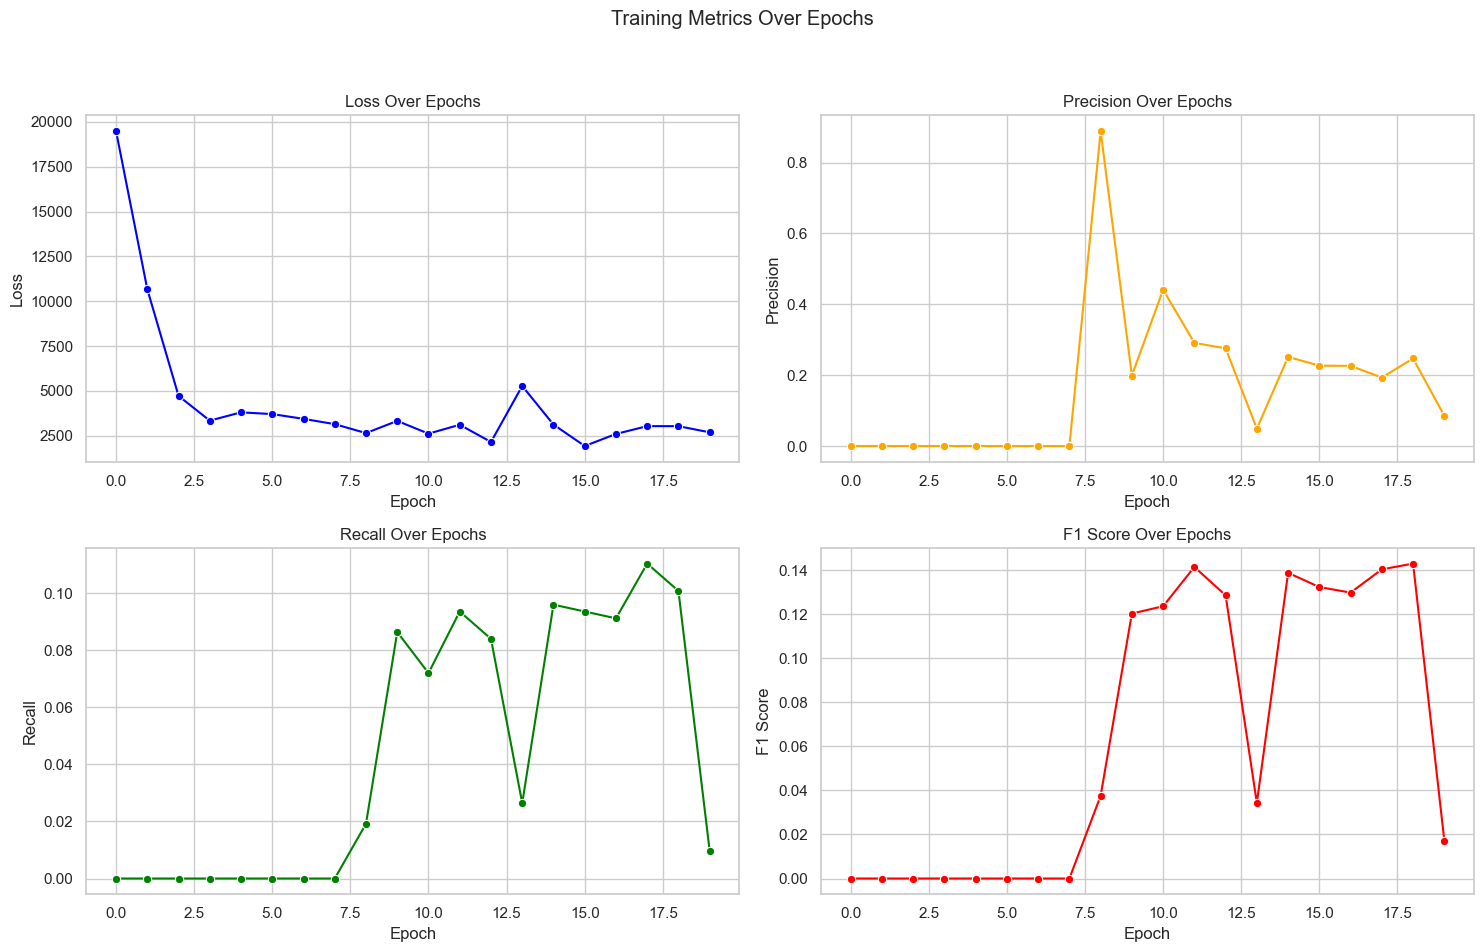

NER Pipeline Progress:  62%|██████▎   | 5/8 [01:57<01:27, 29.05s/it]

[2024-04-11 15:26:51,159: 308: career_chief_logger: INFO: 2833377599:  Training completed successfully.]
[2024-04-11 15:26:51,256: 309: career_chief_logger: INFO: 2833377599:  ℹ Saving to output directory:
artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    439.24    0.00    0.00    0.00    0.00
  6     200       6812.57  26971.95   12.09   25.58    7.91    0.12
 13     400       3761.44  10856.65   31.84   35.28   29.02    0.32
 20     600       5103.76   5940.58   32.88   34.20   31.65    0.33
 26     800       3516.87   3507.13   32.40   36.67   29.

NER Pipeline Progress:  75%|███████▌  | 6/8 [15:41<09:59, 299.54s/it]

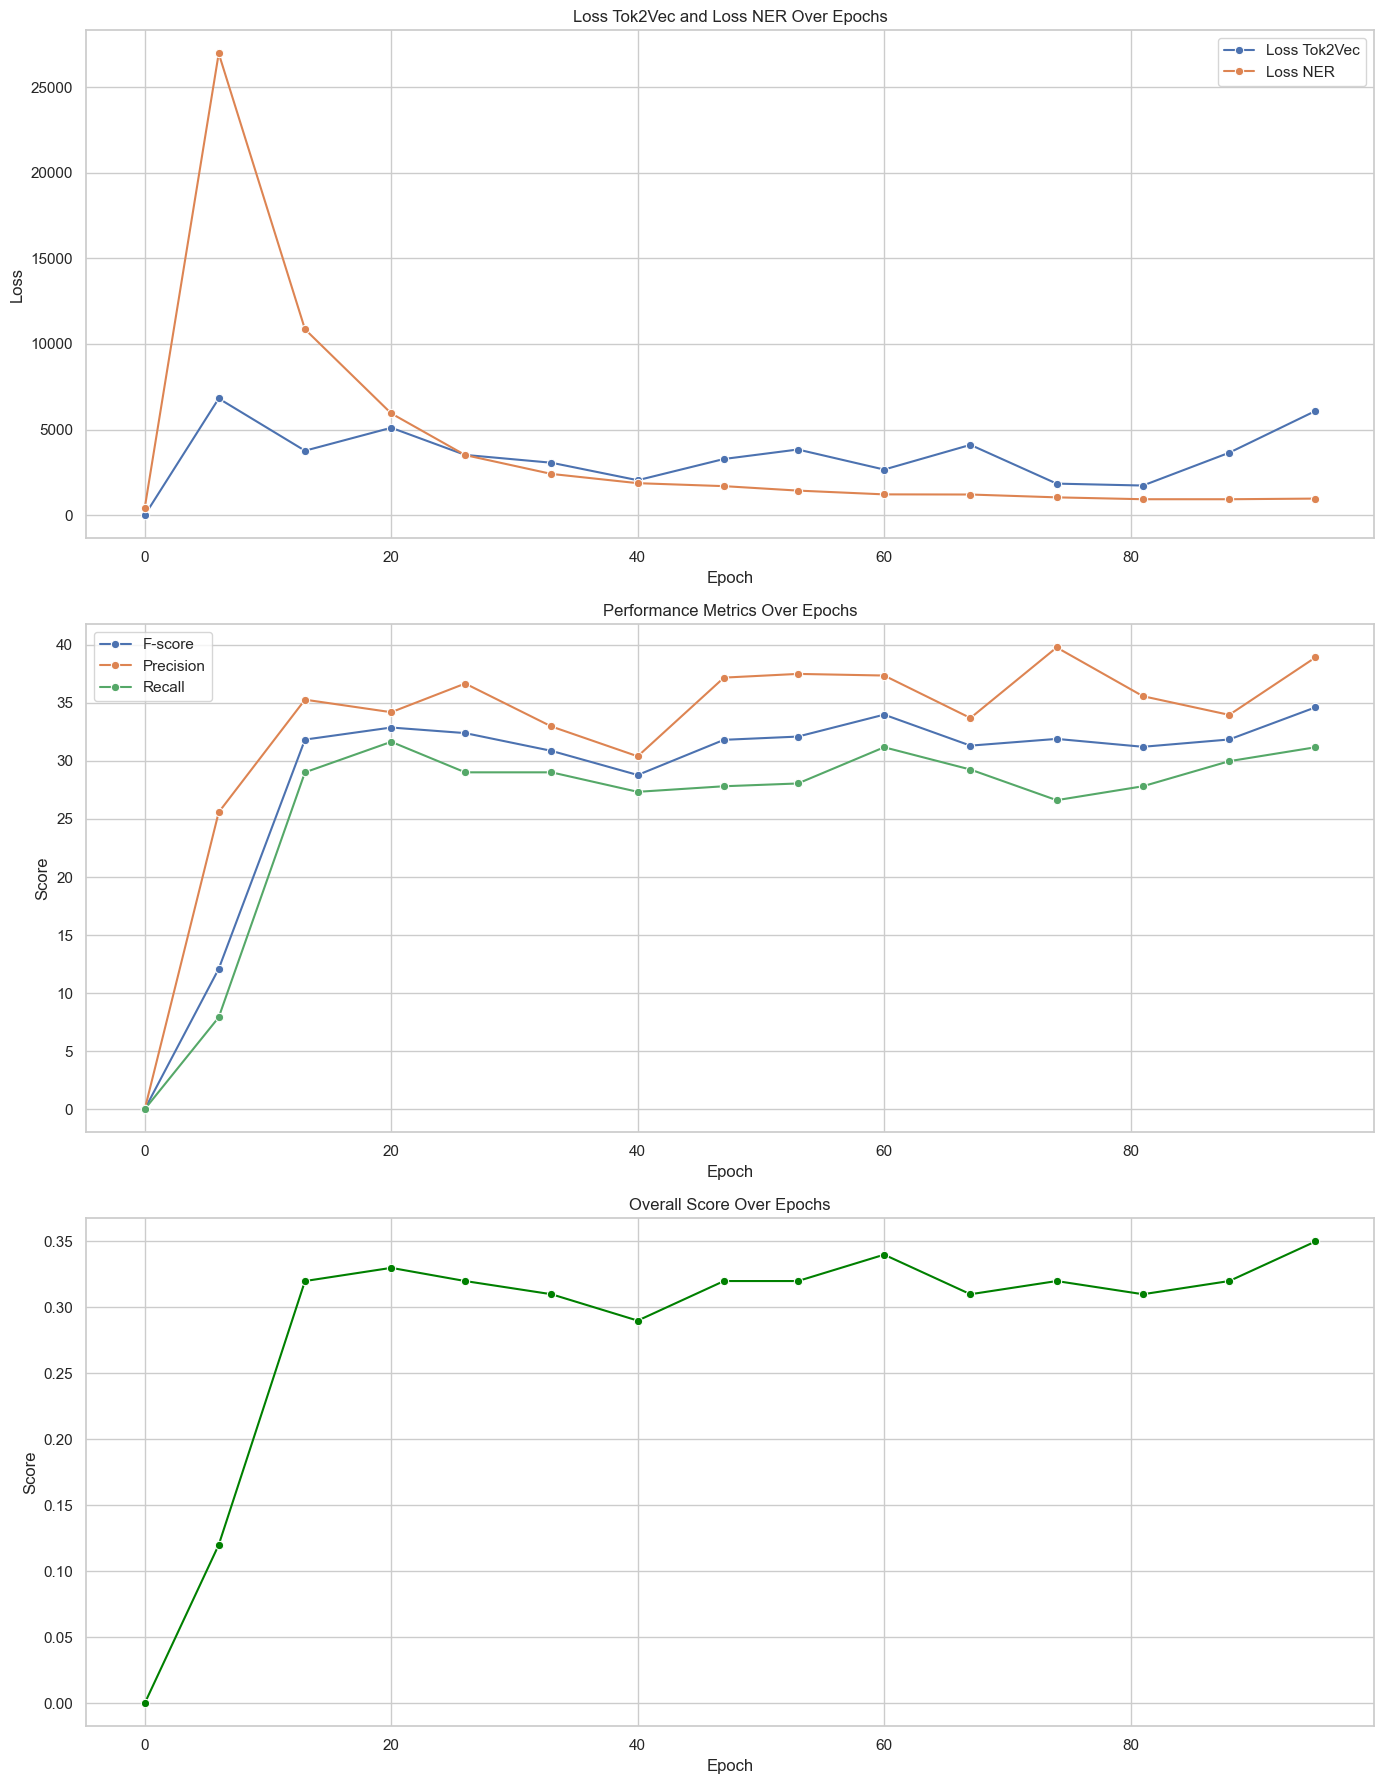

NER Pipeline Progress:  88%|████████▊ | 7/8 [15:43<03:22, 202.17s/it]

[2024-04-11 15:26:53,248: 32: career_chief_logger: INFO: 2131009387:  Loading the fine-tuned NER model.]
[2024-04-11 15:26:53,908: 37: career_chief_logger: INFO: 2131009387:  Loading data from artifacts/data_transformation/train_data.csv.]
[2024-04-11 15:26:58,322: 53: career_chief_logger: INFO: 2131009387:  Starting entity extraction from job descriptions.]


Extracting entities: 100%|██████████| 26572/26572 [11:38<00:00, 38.05it/s]


[2024-04-11 15:38:50,810: 74: career_chief_logger: INFO: 2131009387:  Extracted entities saved successfully to artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/train_data_extracted_entities.csv.]


NER Pipeline Progress: 100%|██████████| 8/8 [27:52<00:00, 209.02s/it]

[2024-04-11 15:39:02,114: 448: career_chief_logger: INFO: 2833377599:  Dataset merging process completed successfully.]
[2024-04-11 15:39:02,116: 451: career_chief_logger: INFO: 2833377599:  NER pipeline completed successfully.]
[2024-04-11 15:39:02,264: 42: career_chief_logger: INFO: 3306622033:  Custom NER spaCy Model Training Pipeline: Training pipeline executed successfully.]


In [42]:
from src.career_chief import logger
from src.career_chief.config.configuration import ConfigurationManager
# from src.career_chief.components.spacy_ner_custom_model import SpacyCustomNERModel

class SpacyCustomNERModelPipeline:
    """
    Orchestrates the pipeline for training a custom spaCy Named Entity Recognition (NER) model.

    This class manages the end-to-end process of configuring, training, and evaluating
    a custom spaCy NER model. It leverages the ConfigurationManager to fetch necessary
    configurations and uses the SpacyCustomNERModel component to execute the training process.
    """

    STAGE_NAME = "Custom NER spaCy Model Training Pipeline"

    def __init__(self):
        """
        Initializes the pipeline with the ConfigurationManager instance
        to access the necessary configurations for the NER model training.
        """
        self.config_manager = ConfigurationManager()
        logger.info(f"{self.STAGE_NAME} initialized successfully.")

    def run_spacy_custom_ner_model(self):
        """
        Executes the spaCy custom NER model training pipeline.

        This method orchestrates the process of loading configurations, processing annotations,
        training the model, and optionally evaluating its performance. It handles and logs
        any errors that occur during the pipeline execution.
        """
        try:
            logger.info(f"{self.STAGE_NAME}: Fetching model configuration.")
            spacy_custom_ner_model_config = self.config_manager.get_spacy_ner_config()

            logger.info(f"{self.STAGE_NAME}: Initializing the SpacyCustomNERModel component.")
            spacy_model_training = SpacyCustomNERModel(config=spacy_custom_ner_model_config)

            logger.info(f"{self.STAGE_NAME}: Executing the training pipeline.")
            spacy_model_training.run()

            logger.info(f"{self.STAGE_NAME}: Training pipeline executed successfully.")

        except Exception as e:
            logger.error(f"{self.STAGE_NAME}: Error occurred during model training - {str(e)}")
            raise e

if __name__ == '__main__':
    pipeline = SpacyCustomNERModelPipeline()
    pipeline.run_spacy_custom_ner_model()


In [51]:
finetuned_data = pd.read_csv('artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/training_metrics_finetuned.csv')
finetuned_data.describe()

,Epoch,Loss Tok2Vec,Loss NER,ENTS_F,ENTS_P,ENTS_R,Score
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,46.866667,3431.235333,4092.278667,28.512667,32.606000,25.725333,0.285333
std,30.397055,1731.076181,6880.424947,9.496228,9.689575,9.081305,0.095234
min,0.000000,0.000000,439.240000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,2349.750000,1001.365000,31.045000,33.335000,27.580000,0.310000
50%,47.000000,3516.870000,1432.050000,31.840000,35.280000,29.020000,0.320000
75%,70.500000,3968.465000,2956.490000,32.250000,37.270000,29.620000,0.320000
max,95.000000,6812.570000,26971.950000,34.620000,39.780000,31.650000,0.350000


In [63]:
custom_ner_data = pd.read_csv('artifacts/model_training/spacy_ner/output/training_metrics_ner_custom.csv')
custom_ner_data.describe()

,epoch,loss,precision,recall,f1
count,20.00000,20.000000,20.000000,20.000000,20.000000
mean,9.50000,4395.808276,0.168733,0.044125,0.064413
std,5.91608,4000.715197,0.216367,0.045423,0.064975
min,0.00000,1930.278102,0.000000,0.000000,0.000000
25%,4.75000,2682.325519,0.000000,0.000000,0.000000
50%,9.50000,3137.480984,0.139192,0.022782,0.035940
75%,14.25000,3734.427627,0.248187,0.091727,0.130543
max,19.00000,19493.127127,0.888889,0.110312,0.143101


For clarity in comparison, we'll also align the epoch numbers between the datasets if needed. ​​



In [64]:
# Prepare the finetuned data by adding a total loss column
finetuned_data['total_loss'] = finetuned_data['Loss Tok2Vec'] + finetuned_data['Loss NER']

# Align the epoch numbering for the custom model to match with the finetuned model, if needed
# Here, it's assumed that the epoch numbers should align directly for a fair comparison. 
# This step may require adjustment based on the specific training regimen of each model.

# Ensure the column names are similar for ease of comparison
finetuned_data_renamed = finetuned_data.rename(columns={
    'Epoch': 'epoch',
    'ENTS_F': 'f1',
    'ENTS_P': 'precision',
    'ENTS_R': 'recall',
    'total_loss': 'loss'
})

# Extract relevant columns to match the custom NER model's data structure
finetuned_data_relevant = finetuned_data_renamed[['epoch', 'loss', 'precision', 'recall', 'f1']]

# Display summary statistics for each dataset to understand the range of values before plotting
custom_ner_data.describe(), finetuned_data_relevant.describe()


(          epoch          loss  precision     recall         f1
 count  20.00000     20.000000  20.000000  20.000000  20.000000
 mean    9.50000   4395.808276   0.168733   0.044125   0.064413
 std     5.91608   4000.715197   0.216367   0.045423   0.064975
 min     0.00000   1930.278102   0.000000   0.000000   0.000000
 25%     4.75000   2682.325519   0.000000   0.000000   0.000000
 50%     9.50000   3137.480984   0.139192   0.022782   0.035940
 75%    14.25000   3734.427627   0.248187   0.091727   0.130543
 max    19.00000  19493.127127   0.888889   0.110312   0.143101,
            epoch          loss  precision     recall         f1
 count  15.000000     15.000000  15.000000  15.000000  15.000000
 mean   46.866667   7523.514000  32.606000  25.725333  28.512667
 std    30.397055   8036.556276   9.689575   9.081305   9.496228
 min     0.000000    439.240000   0.000000   0.000000   0.000000
 25%    23.000000   3888.325000  33.335000  27.580000  31.045000
 50%    47.000000   5264.560000  

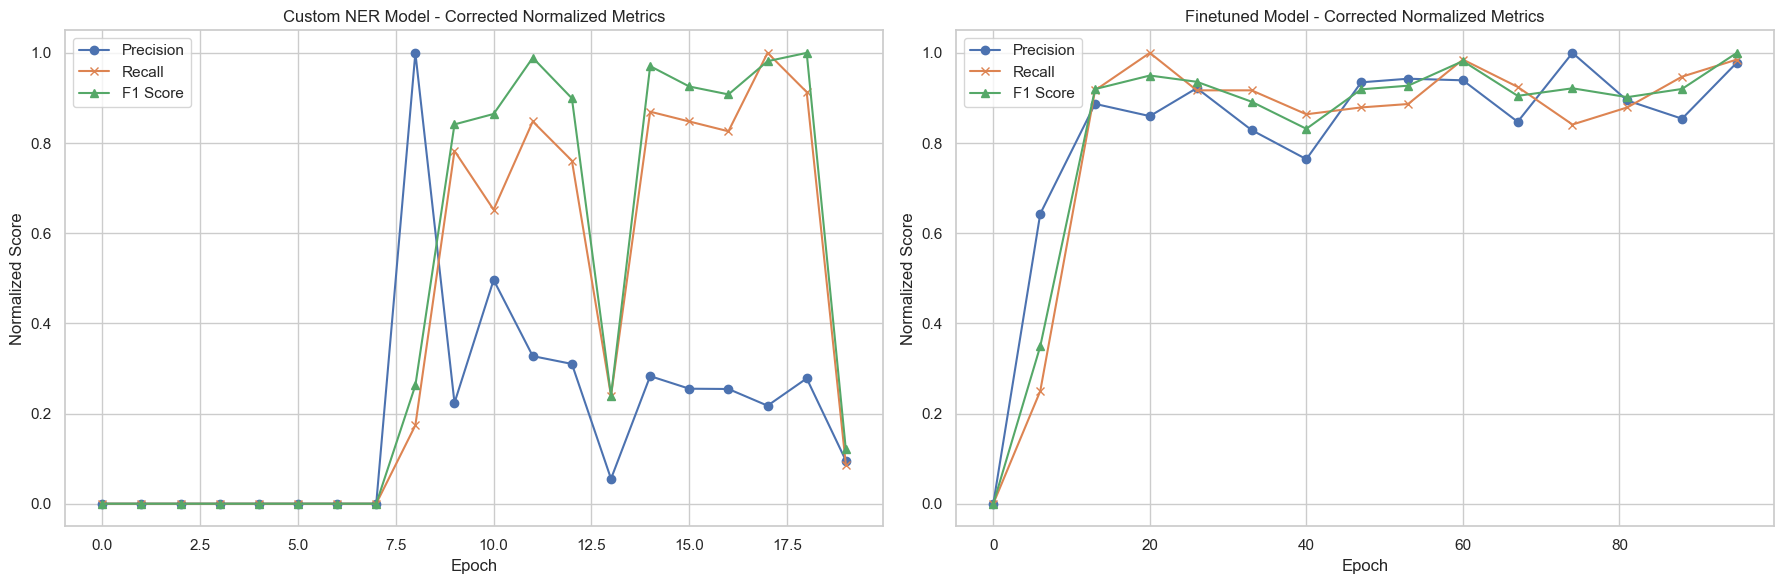

(       precision    recall        f1
 epoch                               
 0       0.000000  0.000000  0.000000
 1       0.000000  0.000000  0.000000
 2       0.000000  0.000000  0.000000
 3       0.000000  0.000000  0.000000
 4       0.000000  0.000000  0.000000
 5       0.000000  0.000000  0.000000
 6       0.000000  0.000000  0.000000
 7       0.000000  0.000000  0.000000
 8       1.000000  0.173913  0.262464
 9       0.223757  0.782609  0.841376
 10      0.496324  0.652174  0.864507
 11      0.327425  0.847826  0.989240
 12      0.310039  0.760870  0.899203
 13      0.055246  0.239130  0.239841
 14      0.283019  0.869565  0.970569
 15      0.255087  0.847826  0.925418
 16      0.254464  0.826087  0.907855
 17      0.217437  1.000000  0.981534
 18      0.277941  0.913043  1.000000
 19      0.095745  0.086957  0.120484,
        precision    recall        f1
 epoch                               
 0       0.000000  0.000000  0.000000
 6       0.643037  0.249921  0.349220
 13      0.

In [66]:
# Redefine normalization and apply it correctly
def normalize_data(data):
    return (data - data.min()) / (data.max() - data.min())

# Normalize the metric columns for both datasets
custom_ner_normalized_correct = custom_ner_data[['precision', 'recall', 'f1']].apply(normalize_data)
finetuned_normalized_correct = finetuned_data_relevant[['precision', 'recall', 'f1']].apply(normalize_data)

# Merge back the epoch data to the normalized datasets
custom_ner_normalized_correct['epoch'] = custom_ner_data['epoch']
finetuned_normalized_correct['epoch'] = finetuned_data_relevant['epoch']

# Create the correct heatmaps for improvement visualization
custom_heatmap_data_correct = custom_ner_normalized_correct.set_index('epoch')
finetuned_heatmap_data_correct = finetuned_normalized_correct.set_index('epoch')

# Plot the normalized metrics with correct data
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.title('Custom NER Model - Corrected Normalized Metrics')
plt.plot(custom_ner_normalized_correct['epoch'], custom_ner_normalized_correct['precision'], label='Precision', marker='o')
plt.plot(custom_ner_normalized_correct['epoch'], custom_ner_normalized_correct['recall'], label='Recall', marker='x')
plt.plot(custom_ner_normalized_correct['epoch'], custom_ner_normalized_correct['f1'], label='F1 Score', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Normalized Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Finetuned Model - Corrected Normalized Metrics')
plt.plot(finetuned_normalized_correct['epoch'], finetuned_normalized_correct['precision'], label='Precision', marker='o')
plt.plot(finetuned_normalized_correct['epoch'], finetuned_normalized_correct['recall'], label='Recall', marker='x')
plt.plot(finetuned_normalized_correct['epoch'], finetuned_normalized_correct['f1'], label='F1 Score', marker='^')
plt.xlabel('Epoch')
plt.ylabel('Normalized Score')
plt.legend()

plt.tight_layout()
plt.show()

# Display the corrected datasets for verification
custom_heatmap_data_correct, finetuned_heatmap_data_correct


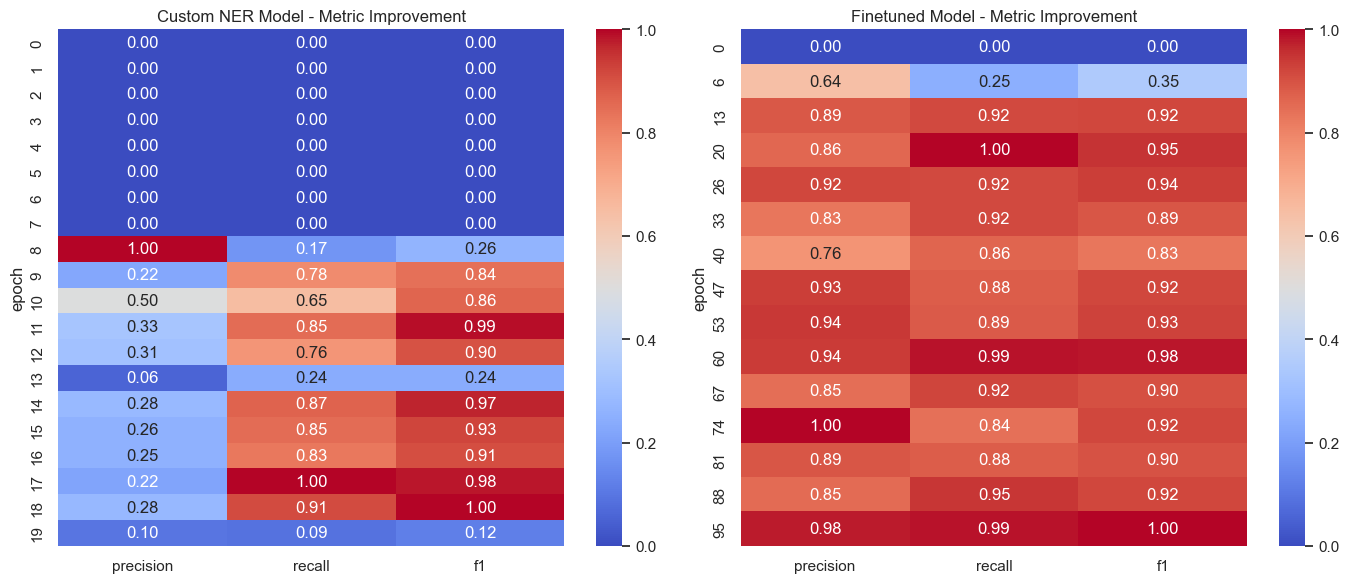

In [67]:
import seaborn as sns

# Setting up the heatmap visualization
plt.figure(figsize=(14, 6))

# Heatmap for the Custom NER Model
plt.subplot(1, 2, 1)
sns.heatmap(custom_heatmap_data_correct, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Custom NER Model - Metric Improvement')

# Heatmap for the Finetuned Model
plt.subplot(1, 2, 2)
sns.heatmap(finetuned_heatmap_data_correct, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Finetuned Model - Metric Improvement')

plt.tight_layout()
plt.show()


In [68]:
train_df = pd.read_csv('artifacts/data_transformation/merged_train_data.csv')

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379910 entries, 0 to 379909
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           379910 non-null  int64  
 1   index                379910 non-null  int64  
 2   title                379910 non-null  object 
 3   company_name         379910 non-null  object 
 4   location             379570 non-null  object 
 5   via                  379826 non-null  object 
 6   description          379910 non-null  object 
 7   extensions           379910 non-null  object 
 8   job_id               379910 non-null  object 
 9   thumbnail            241123 non-null  object 
 10  posted_at            379910 non-null  object 
 11  schedule_type        378070 non-null  object 
 12  work_from_home       131789 non-null  object 
 13  salary               50209 non-null   object 
 14  search_term          379910 non-null  object 
 15  date_time        